# SABR Model Test Code

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
#import sys
#sys.path.insert(sys.path.index('')+1, 'D:/Github/PyFENG')
import pyfeng as pf
import option_models as opt

np.set_printoptions(precision=3)

## 1. Pricing using Hagan's formula (provided)

### (1) SABR for $0<\beta\le 1$

In [3]:
# Parameters
strike = np.linspace(75,125,num=25)
forward = 100
sigma = 0.2
texp = 4
vov = 0.5
rho = -0.5
beta = 1

In [4]:
# Create model
sabr_bsm = pf.SabrHagan2002(sigma, vov=vov, rho=rho, beta=beta)
#sabr_bsm.__dict__

In [5]:
# This is how you price. you can get either price or bsm_vol
price = sabr_bsm.price(strike, forward, texp)
bsm_vol = sabr_bsm.vol_smile(strike, forward, texp)

price, bsm_vol

(array([32.079, 30.519, 28.99 , 27.496, 26.038, 24.617, 23.236, 21.897,
        20.601, 19.35 , 18.146, 16.99 , 15.885, 14.83 , 13.827, 12.877,
        11.98 , 11.136, 10.344,  9.604,  8.914,  8.273,  7.678,  7.129,
         6.622]),
 array([0.243, 0.239, 0.234, 0.23 , 0.226, 0.223, 0.219, 0.215, 0.212,
        0.209, 0.206, 0.203, 0.2  , 0.198, 0.196, 0.193, 0.191, 0.19 ,
        0.188, 0.186, 0.185, 0.184, 0.183, 0.182, 0.181]))

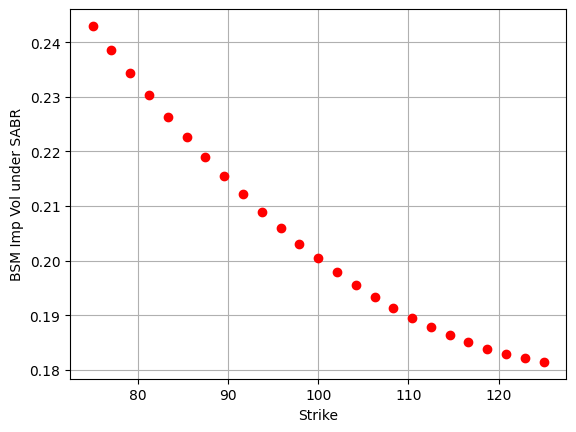

In [6]:
# volatility smile plot: try with different parameters
plt.plot(strike, bsm_vol, 'ro')
#plt.axis([0, 6, 0, 20])
plt.ylabel('BSM Imp Vol under SABR')
plt.xlabel('Strike')
plt.grid()
plt.show()

### (2) SABR for $\beta=0$

In [9]:
strike = np.linspace(75,125,num=25)
#strike = 1
forward = 100
sigma = 20
texp = 4
vov = 0.5
rho = -0.5

In [10]:
sabr_norm = pf.SabrHagan2002(sigma, vov=vov, rho=rho, beta=0)
price = sabr_norm.price(strike, forward, texp)
nvol = sabr_norm.vol_smile(strike, forward, texp, model='norm')

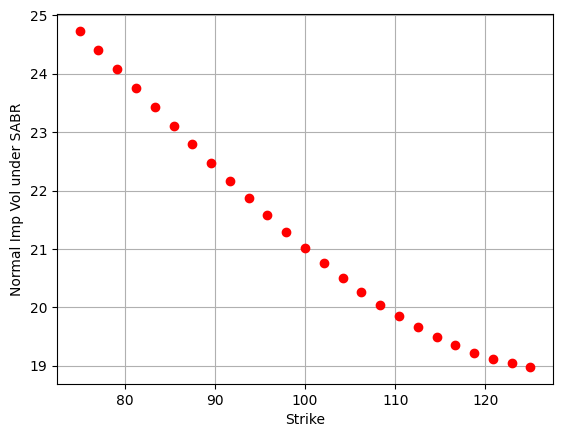

In [11]:
plt.plot(strike, nvol, 'ro')
#plt.axis([0, 6, 0, 20])
plt.ylabel('Normal Imp Vol under SABR')
plt.xlabel('Strike')
plt.grid()
plt.show()

### (3) Smile calibration to 3 options

In [12]:
strike3 = np.array([90, 100, 110])
price3 = sabr_bsm.price(strike3, forward, texp)
vol3 = sabr_bsm.vol_smile(strike3, forward, texp)

price3, vol3

(array([21.634, 15.885, 11.301]), array([0.215, 0.2  , 0.19 ]))

In [15]:
sabr_bsm.__dict__

{'sigma': 0.2,
 'intr': 0.0,
 'divr': 0.0,
 'is_fwd': False,
 'vov': 0.5,
 'rho': -0.5,
 'beta': 1}

In [16]:
# makre sure this return the original sigma, alpha, rho
sabr_bsm.calibrate3(vol3, strike3, forward, texp, is_vol=True)

{'sigma': 0.19999999999442344,
 'vov': 0.500000000009505,
 'rho': -0.49999999988780375}

In [17]:
# makre sure this return the original sigma, alpha, rho
sabr_bsm.calibrate3(price3, strike3, forward, texp, is_vol=False)

{'sigma': 0.19999999999442356,
 'vov': 0.5000000000095046,
 'rho': -0.49999999988780425}

## 2. Pricing under MC method

In [18]:
strike = np.linspace(75,125,num=25)
forward = 100

In [21]:
dt = 0.1
n_path = 10000
texp = 2

n_dt = int(np.ceil(texp / dt))
tobs = np.arange(1, n_dt + 1) / n_dt * texp
dt = texp / n_dt
assert texp == tobs[-1]

Z_t = np.cumsum(np.random.standard_normal((n_dt, n_path)) * np.sqrt(dt), axis=0)
sigma_t = np.exp(vov * (Z_t - vov/2 * tobs[:, None]))
sigma_t = np.insert(sigma_t, 0, np.ones(sigma_t.shape[1]), axis=0)

### (1) SABR for $\beta=1$

In [140]:
# instantiate mc model from the hagan model's parameters
print(sabr_bsm.__dict__)
sabr_bsm_mc = opt.sabr.ModelBsmMC(sabr_bsm.sigma, vov=sabr_bsm.vov, rho=sabr_bsm.rho, beta=1)

{'sigma': 0.2, 'intr': 0.0, 'divr': 0.0, 'is_fwd': False, 'vov': 0.5, 'rho': -0.5, 'beta': 1}


In [141]:
sabr_bsm_mc.__dict__

{'sigma': 0.2, 'vov': 0.5, 'rho': -0.5, 'beta': 1, 'intr': 0.0}

In [183]:
price_hagan = sabr_bsm.price(strike, forward, texp)
price_mc = sabr_bsm_mc.price(strike, forward, texp)

# make sure the two prices are similar
price_hagan, price_mc

(array([28.311, 26.622, 24.972, 23.364, 21.801, 20.285, 18.821, 17.411,
        16.057, 14.763, 13.53 , 12.361, 11.258, 10.221,  9.253,  8.351,
         7.517,  6.749,  6.046,  5.404,  4.822,  4.297,  3.825,  3.401,
         3.024]),
 array([28.463, 26.77 , 25.113, 23.499, 21.93 , 20.411, 18.944, 17.533,
        16.183, 14.892, 13.666, 12.502, 11.403, 10.372,  9.406,  8.506,
         7.67 ,  6.899,  6.195,  5.557,  4.98 ,  4.461,  3.99 ,  3.566,
         3.186]))

### (2) SABR for $\beta=0$

In [113]:
# instantiate mc model from the hagan model's parameters
print(sabr_norm.__dict__)
sabr_norm_mc = opt.sabr.ModelNormMC(sabr_norm.sigma, vov=sabr_norm.vov, rho=sabr_norm.rho, beta=0)

{'sigma': 20, 'intr': 0.0, 'divr': 0.0, 'is_fwd': False, 'vov': 0.5, 'rho': -0.5, 'beta': 0}


In [187]:
price_hagan = sabr_norm.price(strike, forward, texp)
price_mc = sabr_norm_mc.price(strike, forward, texp)

# make sure the two prices are similar
price_hagan, price_mc

(array([29.641, 27.915, 26.219, 24.555, 22.927, 21.337, 19.789, 18.287,
        16.833, 15.431, 14.085, 12.798, 11.574, 10.417,  9.328,  8.31 ,
         7.366,  6.495,  5.699,  4.976,  4.325,  3.743,  3.226,  2.772,
         2.374]),
 array([29.093, 27.381, 25.699, 24.05 , 22.438, 20.865, 19.337, 17.857,
        16.428, 15.053, 13.737, 12.485, 11.3  , 10.184,  9.135,  8.155,
         7.244,  6.4  ,  5.628,  4.923,  4.286,  3.713,  3.202,  2.751,
         2.358]))

## 3. Pricing under conditional MC method

In [19]:
strike = np.linspace(75,125,num=25)
forward = 100

### (1) SABR for $\beta=1$

In [219]:
# instantiate mc model from the hagan model's parameters
print(sabr_bsm.__dict__)
sabr_bsm_cmc = opt.sabr.ModelBsmCondMC(sabr_bsm.sigma, vov=sabr_bsm.vov, rho=sabr_bsm.rho, beta=1)

{'sigma': 0.2, 'intr': 0.0, 'divr': 0.0, 'is_fwd': False, 'vov': 0.5, 'rho': -0.5, 'beta': 1}


In [230]:
price_hagan = sabr_bsm.price(strike, forward, texp)
price_mc = sabr_bsm_cmc.price(strike, forward, texp)

# make sure the two prices are similar
price_hagan, price_mc

(array([28.311, 26.622, 24.972, 23.364, 21.801, 20.285, 18.821, 17.411,
        16.057, 14.763, 13.53 , 12.361, 11.258, 10.221,  9.253,  8.351,
         7.517,  6.749,  6.046,  5.404,  4.822,  4.297,  3.825,  3.401,
         3.024]),
 array([28.093, 26.407, 24.761, 23.159, 21.603, 20.096, 18.641, 17.242,
        15.9  , 14.619, 13.4  , 12.246, 11.158, 10.136,  9.182,  8.295,
         7.474,  6.718,  6.026,  5.394,  4.82 ,  4.302,  3.835,  3.416,
         3.041]))

### (2) SABR for $\beta=0$

In [214]:
# instantiate mc model from the hagan model's parameters
print(sabr_norm.__dict__)
sabr_norm_cmc = opt.sabr.ModelNormCondMC(sabr_norm.sigma, vov=sabr_norm.vov, rho=sabr_norm.rho, beta=0)

{'sigma': 20, 'intr': 0.0, 'divr': 0.0, 'is_fwd': False, 'vov': 0.5, 'rho': -0.5, 'beta': 0}


In [224]:
price_hagan = sabr_norm.price(strike, forward, texp)
price_mc = sabr_norm_cmc.price(strike, forward, texp)

# make sure the two prices are similar
price_hagan, price_mc

(array([29.641, 27.915, 26.219, 24.555, 22.927, 21.337, 19.789, 18.287,
        16.833, 15.431, 14.085, 12.798, 11.574, 10.417,  9.328,  8.31 ,
         7.366,  6.495,  5.699,  4.976,  4.325,  3.743,  3.226,  2.772,
         2.374]),
 array([29.662, 27.934, 26.237, 24.574, 22.948, 21.361, 19.817, 18.32 ,
        16.872, 15.477, 14.139, 12.861, 11.646, 10.497,  9.416,  8.406,
         7.469,  6.604,  5.811,  5.091,  4.44 ,  3.857,  3.339,  2.88 ,
         2.477]))

## 4. Compare the MC variance between regular vs conditional MC

### Repeat the pricing for 100 times and compare the mean and stdev of the results

In [248]:
# Normal model

# regular MC
a = np.zeros((100, 25))
for i in range(100):
    sabr_norm_mc = opt.sabr.ModelNormMC(sabr_norm.sigma, vov=sabr_norm.vov, rho=sabr_norm.rho, beta=0)
    price_mc = sabr_norm_mc.price(strike, forward, texp)
    a[i, :] = price_mc
print(a.mean(axis=0))
print(a.std(axis=0))

# conditional MC
b = np.zeros((100, 25))
for i in range(100):
    sabr_norm_mc = opt.sabr.ModelNormCondMC(sabr_norm.sigma, vov=sabr_norm.vov, rho=sabr_norm.rho, beta=0)
    price_mc = sabr_norm_mc.price(strike, forward, texp)
    b[i, :] = price_mc
print(b.mean(axis=0))
print(b.std(axis=0))


[29.49  27.771 26.083 24.43  22.814 21.238 19.705 18.219 16.783 15.401
 14.075 12.808 11.604 10.466  9.395  8.393  7.463  6.604  5.815  5.098
  4.449  3.866  3.347  2.888  2.484]
[0.237 0.232 0.228 0.223 0.217 0.212 0.205 0.199 0.193 0.186 0.18  0.174
 0.167 0.16  0.154 0.147 0.14  0.133 0.126 0.118 0.11  0.103 0.096 0.089
 0.083]
[29.551 27.827 26.134 24.475 22.852 21.269 19.729 18.236 16.791 15.4
 14.065 12.79  11.578 10.432  9.355  8.348  7.413  6.55   5.761  5.043
  4.396  3.816  3.3    2.844  2.445]
[0.077 0.074 0.07  0.067 0.063 0.06  0.056 0.052 0.049 0.045 0.042 0.039
 0.036 0.033 0.03  0.027 0.025 0.023 0.021 0.019 0.018 0.016 0.015 0.014
 0.013]


In [250]:
# BSM model

# regular MC
a = np.zeros((100, 25))
for i in range(100):
    sabr_norm_mc = opt.sabr.ModelBsmMC(sabr_bsm.sigma, vov=sabr_bsm.vov, rho=sabr_bsm.rho, beta=1)
    price_mc = sabr_norm_mc.price(strike, forward, texp)
    a[i, :] = price_mc
print(a.mean(axis=0))
print(a.std(axis=0))

# conditional MC
b = np.zeros((100, 25))
for i in range(100):
    sabr_norm_mc = opt.sabr.ModelBsmCondMC(sabr_bsm.sigma, vov=sabr_bsm.vov, rho=sabr_bsm.rho, beta=1)
    price_mc = sabr_norm_mc.price(strike, forward, texp)
    b[i, :] = price_mc
print(b.mean(axis=0))
print(b.std(axis=0))

[28.141 26.455 24.809 23.207 21.652 20.148 18.697 17.301 15.964 14.687
 13.472 12.323 11.238 10.221  9.27   8.386  7.567  6.812  6.12   5.488
  4.912  4.392  3.922  3.499  3.12 ]
[0.259 0.253 0.247 0.241 0.235 0.228 0.22  0.212 0.205 0.197 0.188 0.18
 0.173 0.165 0.158 0.15  0.143 0.136 0.129 0.123 0.117 0.112 0.107 0.103
 0.098]
[28.142 26.455 24.807 23.203 21.645 20.136 18.68  17.278 15.935 14.651
 13.43  12.273 11.182 10.158  9.201  8.311  7.488  6.73   6.035  5.401
  4.825  4.305  3.836  3.416  3.04 ]
[0.091 0.087 0.083 0.079 0.075 0.071 0.067 0.062 0.058 0.054 0.049 0.045
 0.041 0.037 0.034 0.031 0.028 0.025 0.022 0.02  0.018 0.017 0.015 0.014
 0.013]
